In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disease-prediction-using-machine-learning/Training.csv
/kaggle/input/disease-prediction-using-machine-learning/Testing.csv


### Content
* [Import Data](#1)
* [Data Cleaning](#2)
* [KNN](#3)
    * [Model Complexity](#4)
    * [Cross Validation](#5)
* [Decision Tree Classifier](#6)
* [Random Forest Classifier](#7)
* [Support Vector Classifier](#8)
* [Logistic Regression](#9)
* [Metrics](#10)

<a id = "1"></a>
#### Import Data

* First look at data
* We must read our csv files from directory

In [2]:
data_dir = "../input/disease-prediction-using-machine-learning"
train_df = pd.read_csv(data_dir + "/Training.csv")
test_df = pd.read_csv(data_dir + "/Testing.csv")
train_df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 134 entries, itching to Unnamed: 133
dtypes: float64(1), int64(132), object(1)
memory usage: 5.0+ MB


There are 4920 samples and 134 features in the dataset. First we have to dive into deeper of the data so we can completely understand it. The data is clean and balanced so we dont need to handle with missing values, outliers etc. Just one column will be dropped below stages of this kernel

In [4]:
# display 30-60. indices of columns. 
train_df.columns[30:60]

Index(['indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea',
       'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain', 'constipation',
       'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine',
       'yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload',
       'swelling_of_stomach', 'swelled_lymph_nodes', 'malaise',
       'blurred_and_distorted_vision', 'phlegm', 'throat_irritation',
       'redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion',
       'chest_pain', 'weakness_in_limbs', 'fast_heart_rate',
       'pain_during_bowel_movements'],
      dtype='object')

In [5]:
# all of these are encoded data and types are integer.
train_df["indigestion"]

0       0
1       0
2       0
3       0
4       0
       ..
4915    0
4916    0
4917    0
4918    0
4919    0
Name: indigestion, Length: 4920, dtype: int64

In [6]:
train_df["prognosis"].unique()

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo'], dtype=object)

Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
Allergy      

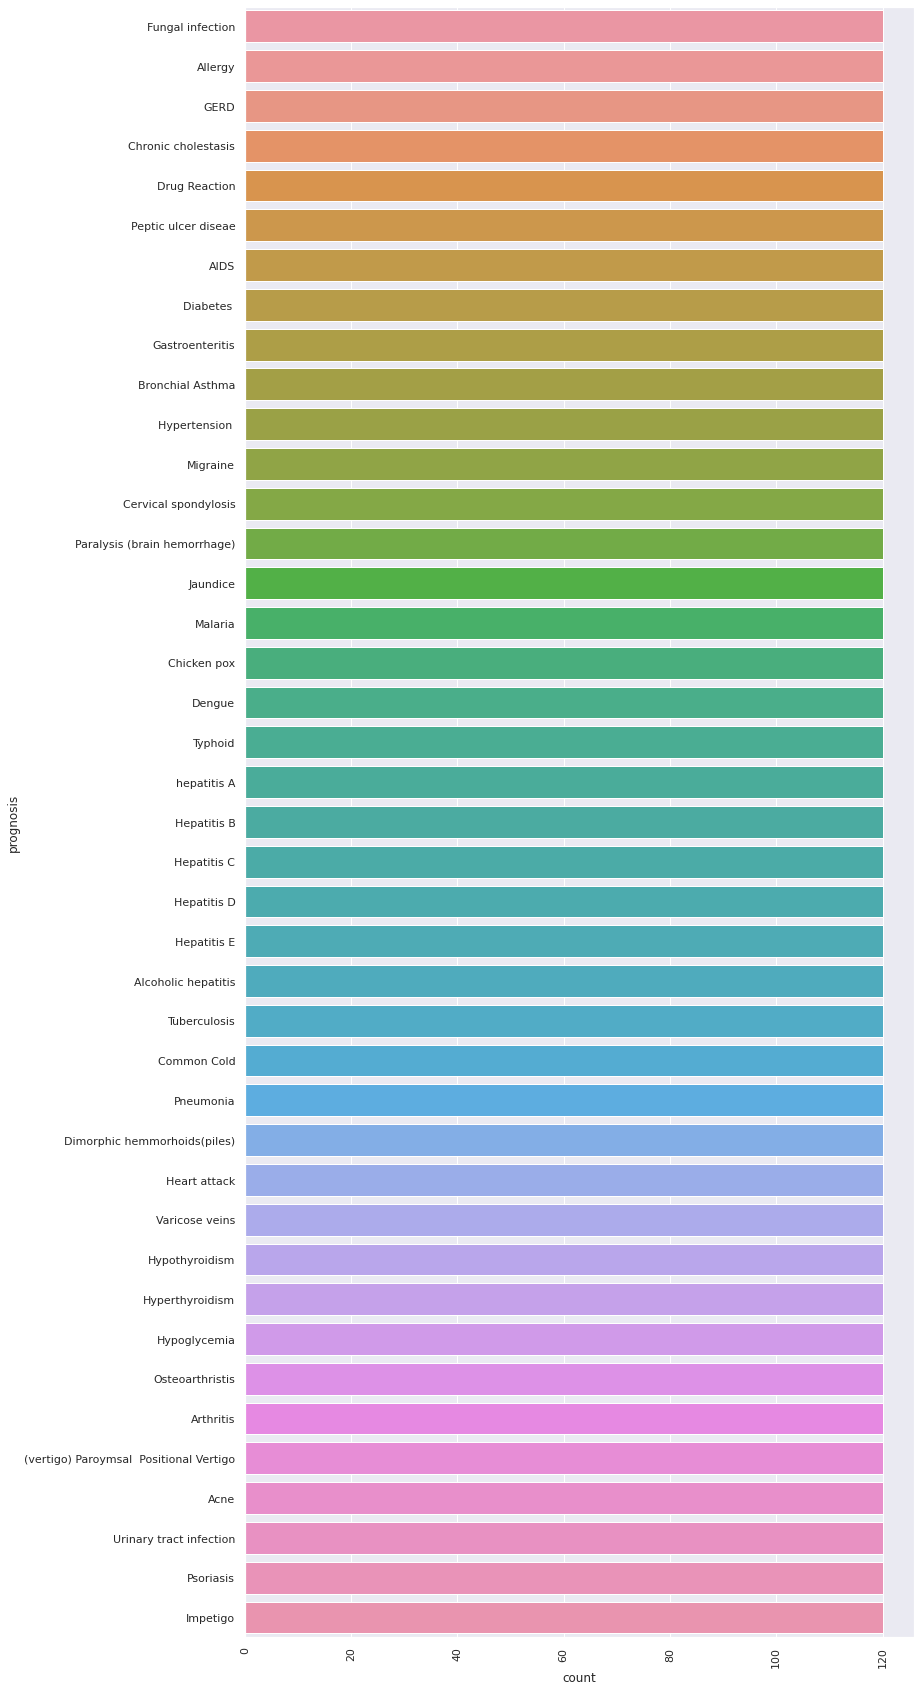

In [7]:
# the data is balanced for classification training. lets see value counts and also visualize them
sns.set_theme(style="darkgrid")
plt.figure(figsize = (12,30))
plt.xticks(rotation = 90)
sns.countplot(y="prognosis", data=train_df)
print(train_df["prognosis"].value_counts())

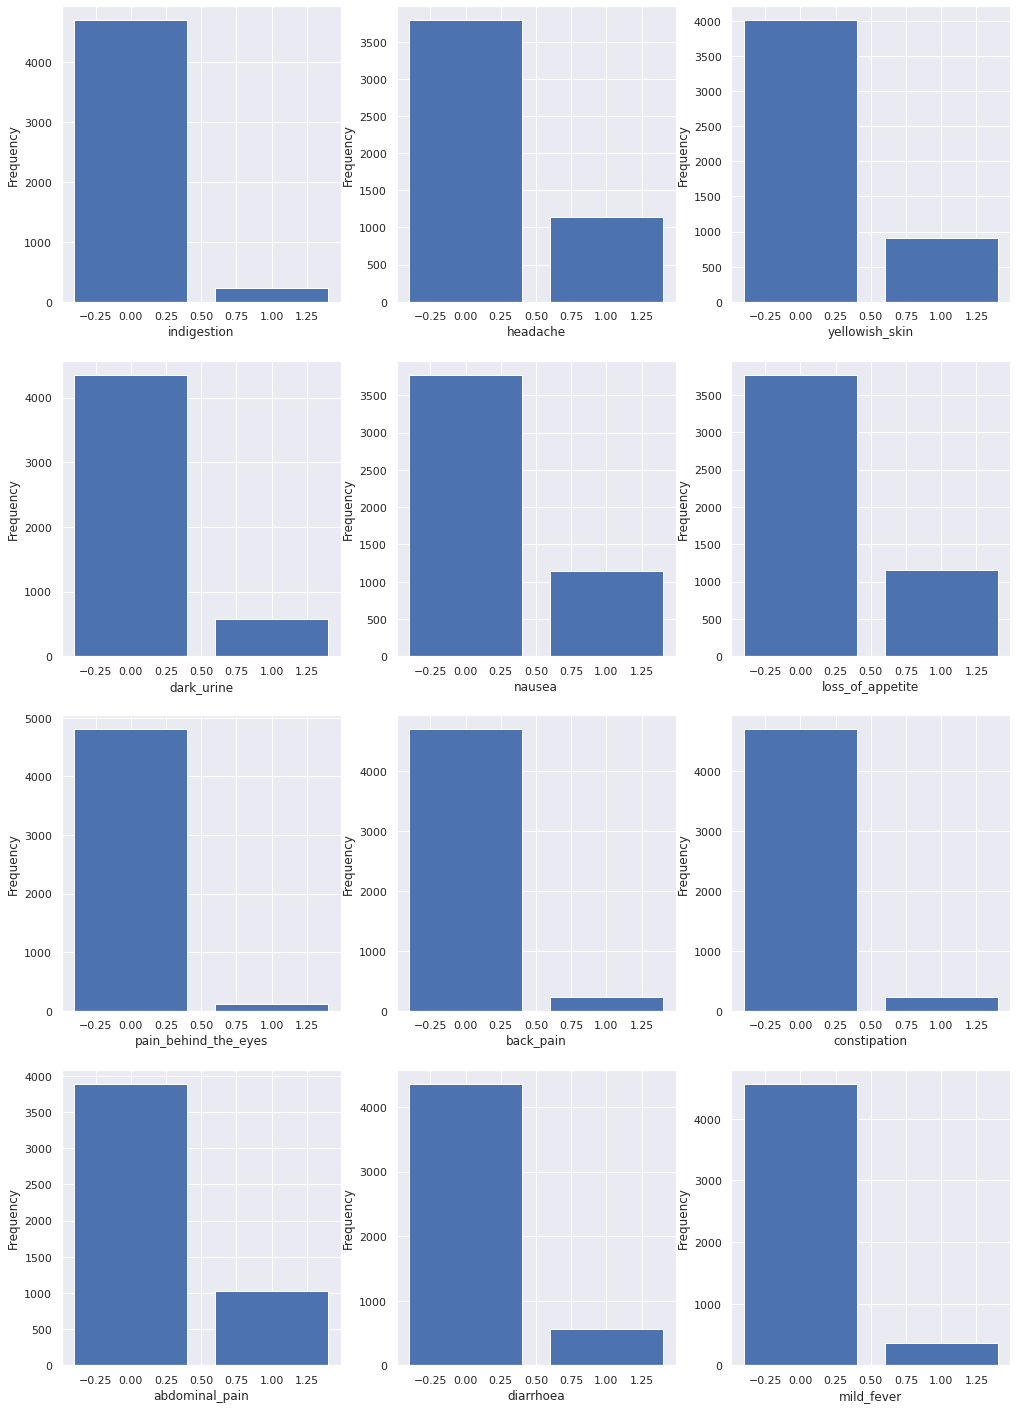

In [8]:
# lets visualize some of features
features = ['indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea',
       'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain', 'constipation',
       'abdominal_pain', 'diarrhoea', 'mild_fever']

plt.figure(figsize = (17,25))
for i, feature in enumerate(features):
    plt.subplot(4,3,i+1)
    plt.bar(train_df[feature].value_counts().index.to_numpy(), train_df[feature].value_counts().values)
    plt.xlabel(feature)
    plt.ylabel("Frequency")
plt.show()

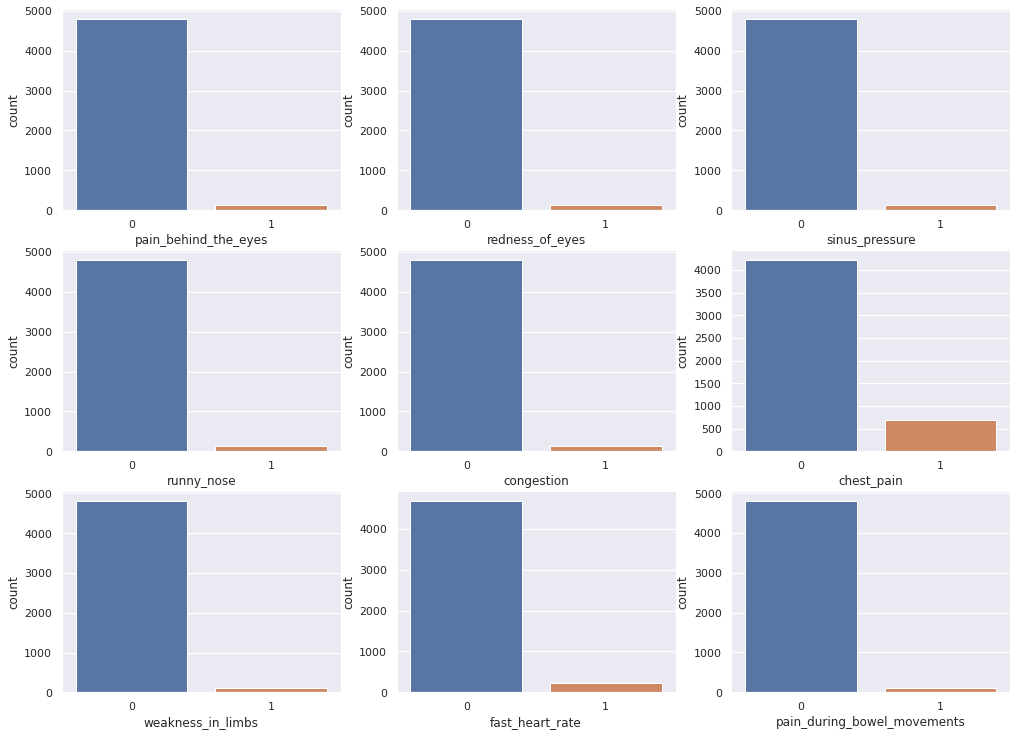

In [9]:
# visualize it with seaborn library one more time
features = ['pain_behind_the_eyes', 'redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion',
       'chest_pain', 'weakness_in_limbs', 'fast_heart_rate',
       'pain_during_bowel_movements']

plt.figure(figsize = (17,17))
for i, feature in enumerate(features):
    plt.subplot(4,3,i+1)
    sns.countplot(x = feature, data = train_df)
    plt.xlabel(feature)
plt.show()

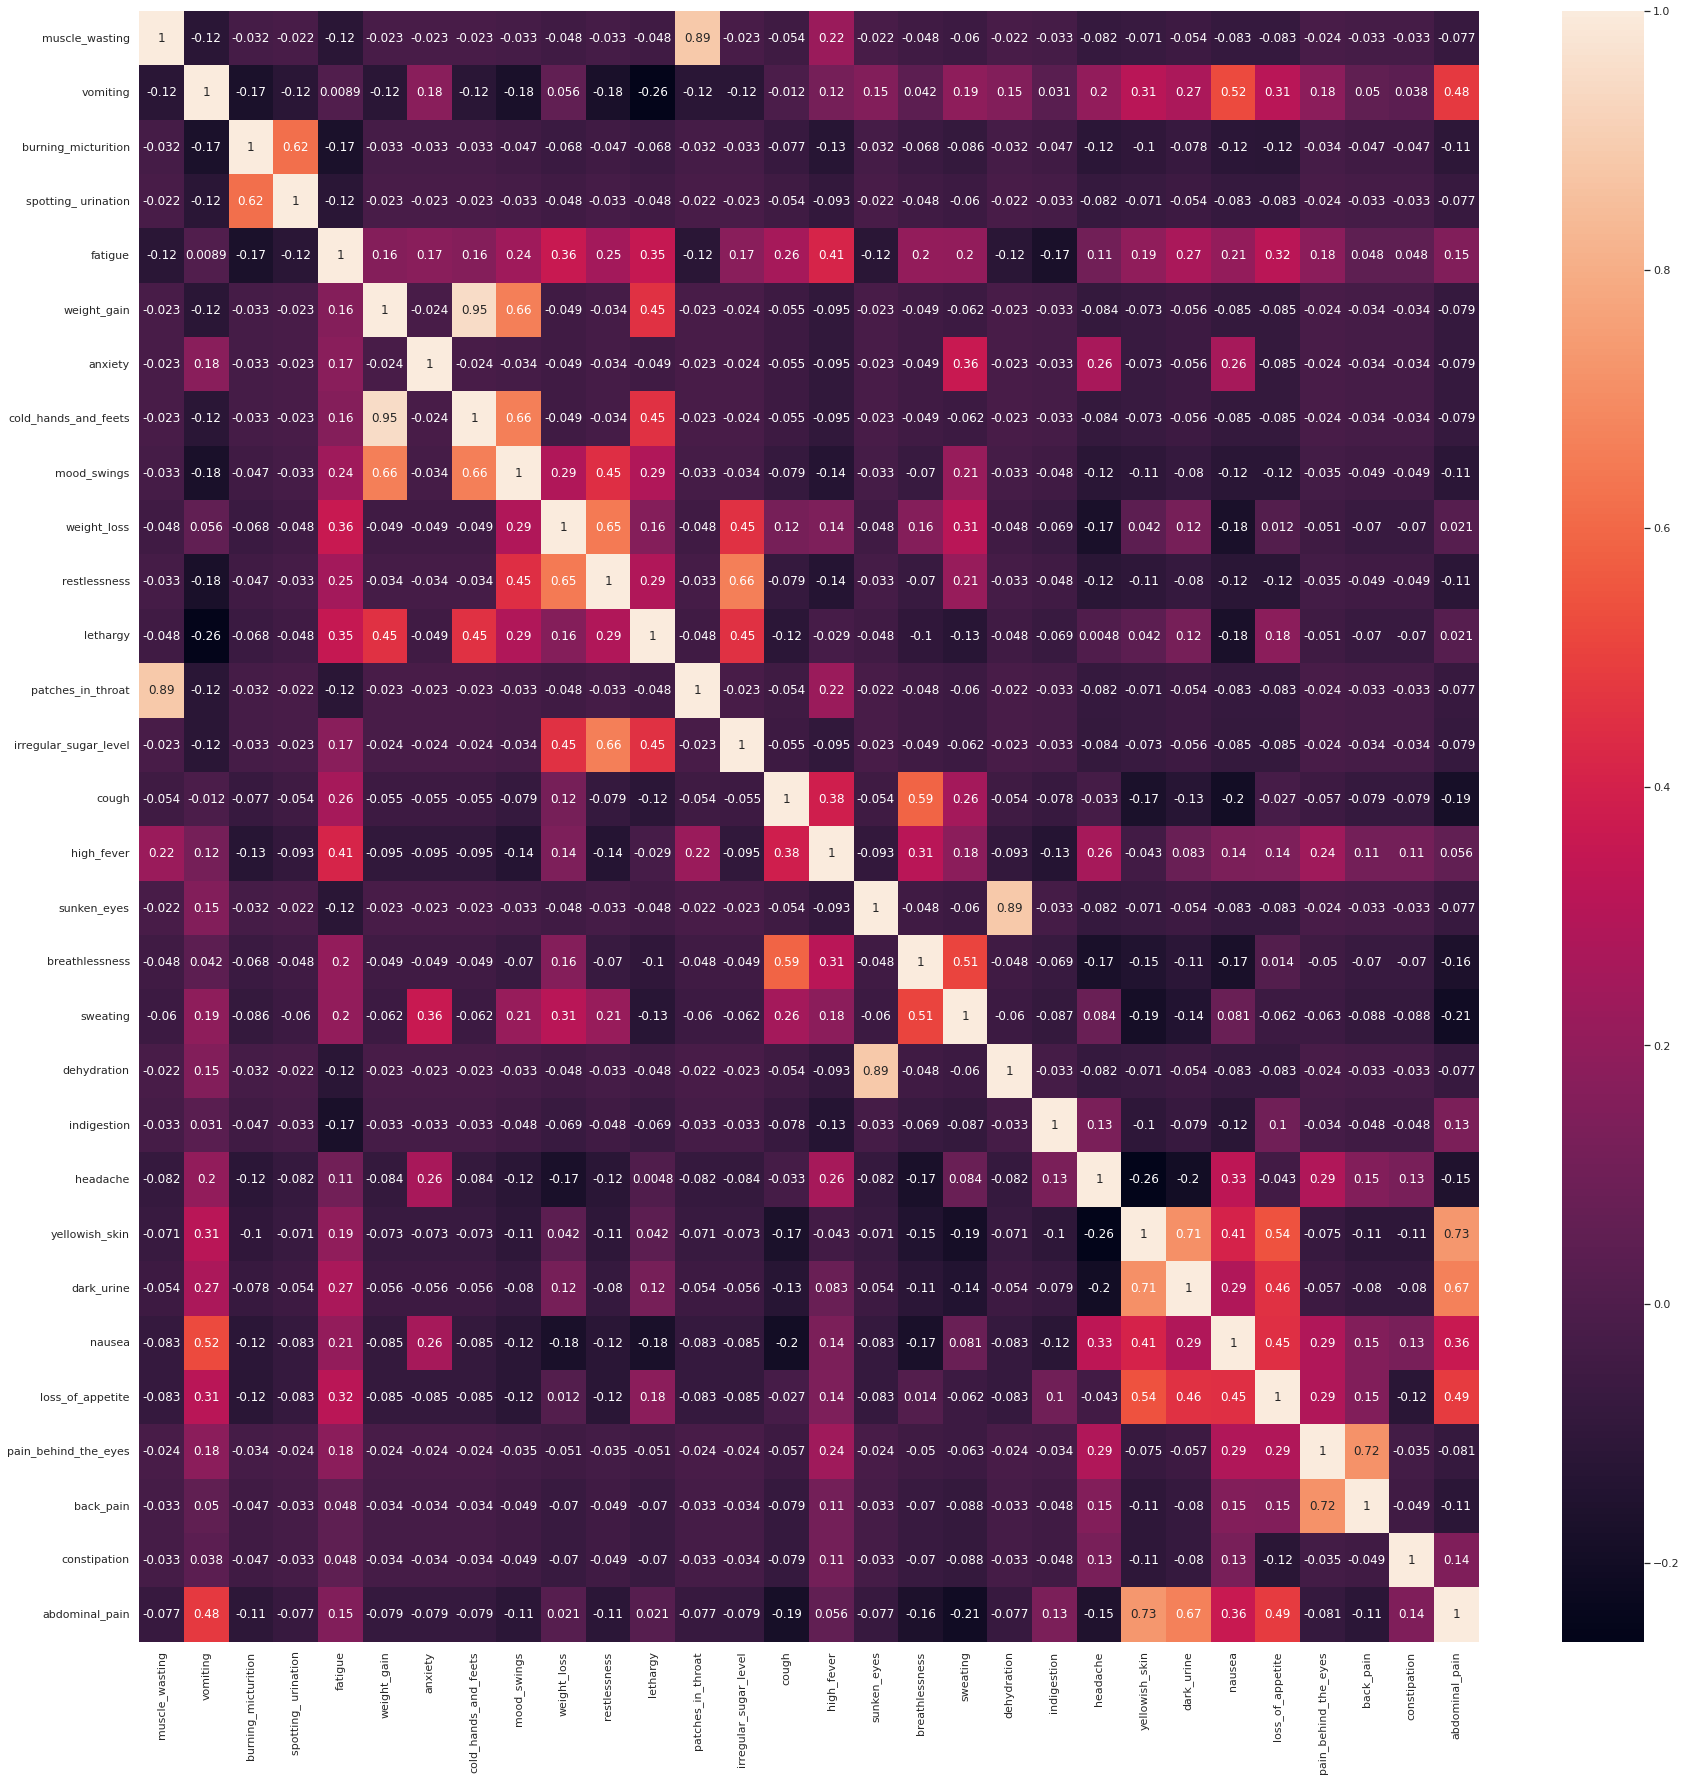

In [10]:
# linear relationships between some of features using correlation heatmap: for example which symptoms occur together?
df_corr = train_df.iloc[:, 10:40]
plt.figure(figsize = (30, 30))
sns.heatmap(df_corr.corr(), annot = True)
plt.show()

as we look at from correlation map, we can infer these:
* yellowish skin and abdominal pain have a high correlation coefficent which means these features usually seem together (maybe a liver problem)
* cough and breathlessness also have high correlation (it's usual because lung diseases give the same symptoms)
* restlessness and irregular sugar usually seem together

<a id = "2"></a>
#### Data Cleaning

In [11]:
# drop unnamed feature from train data
train_df.drop("Unnamed: 133", axis = 1, inplace = True)
# train_df["Unnamed: 133"]  # it's not here anymore

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 5.0+ MB


In [13]:
train_df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


OK. Now let's create our ML models
<a id = "3"></a>
### KNN

In [14]:
# Modelling
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)  # k = 5
x_train, y_train = train_df.loc[:,train_df.columns != "prognosis"], train_df.loc[:,"prognosis"]
x_test, y_test = test_df.loc[:,train_df.columns != "prognosis"], test_df.loc[:,"prognosis"]
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)
print("Prediction list: {}".format(prediction[0:20]))
print("With KNN (K=5) accuracy is: ",knn.score(x_test, y_test))

Prediction list: ['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
 'Peptic ulcer diseae' 'AIDS' 'Diabetes ' 'Gastroenteritis'
 'Bronchial Asthma' 'Hypertension ' 'Migraine' 'Cervical spondylosis'
 'Paralysis (brain hemorrhage)' 'Jaundice' 'Malaria' 'Chicken pox'
 'Dengue' 'Typhoid' 'hepatitis A']
With KNN (K=5) accuracy is:  1.0


<a id = "4"></a>
#### Model Complexity

In fact, this dataset doesnt requires tuning, but I want to try basics of complex modelling

In [15]:
neighbors = np.arange(1,25)   # for k tuning
train_accuracy = []
test_accuracy = []
# Loop for different k values
for i, k in enumerate(neighbors):
    # k from 1 to 25 (excluded)
    knn = KNeighborsClassifier(n_neighbors = k)
    # fit the knn
    knn.fit(x_train, y_train)
    # train accuracy
    train_accuracy.append(knn.score(x_train, y_train))
    # test accuracy
    test_accuracy.append(knn.score(x_test, y_test))

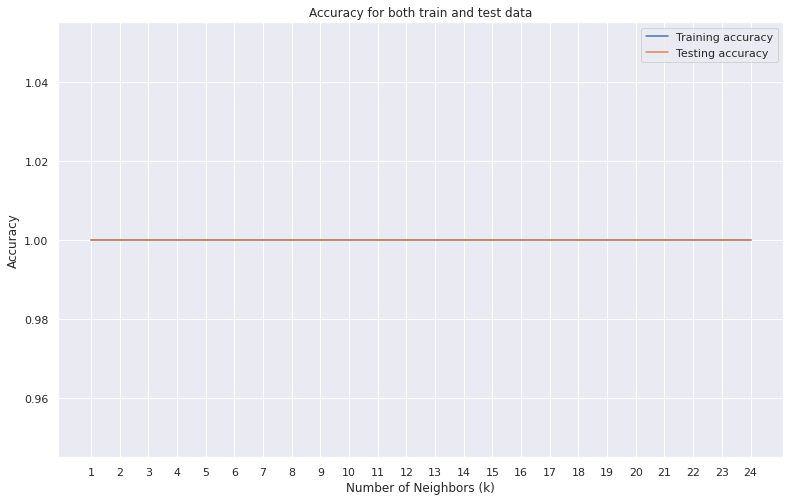

In [16]:
# Plot the accuracies
plt.figure(figsize = (13,8))
plt.plot(neighbors, train_accuracy, label = "Training accuracy")
plt.plot(neighbors, test_accuracy, label = "Testing accuracy")
plt.legend()
plt.title("Accuracy for both train and test data")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(neighbors)
plt.show()

<a id = "5"></a>
#### Cross Validation

In [17]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
k = 5 # for K-fold cross validation
cv_result = cross_val_score(knn, x_train, y_train, cv = k) # uses R^2 score
print("CV scores: ", cv_result)
print("CV scores average: ", np.sum(cv_result)/len(cv_result))

CV scores:  [1. 1. 1. 1. 1.]
CV scores average:  1.0


<a id = "6"></a>
#### Decision Tree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(x_train, y_train)
dt.predict(x_test)
dt.score(x_test, y_test)

0.9761904761904762

<a id = "7"></a>
#### Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42, n_estimators = 100)
rfc.fit(x_train, y_train)
rfc.predict(x_test)
rfc.score(x_test, y_test)

0.9761904761904762

<a id = "8"></a>
#### Support Vector Classifier

In [20]:
from sklearn.svm import SVC
svc = SVC(gamma = "auto", kernel = "rbf" )
svc.fit(x_train, y_train)
svc.predict(x_test)
svc.score(x_test, y_test)

1.0

<a id = "9"></a>
#### Logistic Regression Classifier

In [21]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state = 42)
logreg.fit(x_train, y_train)
logreg.predict(x_test)
logreg.score(x_test, y_test)

1.0

<a id = "10"></a>
#### Metrics

In [22]:
y_predictions = {"KNN": knn.predict(x_test),
          "SVC": svc.predict(x_test),
          "DT": dt.predict(x_test),
          "RFC": rfc.predict(x_test),
          "LOGREG": logreg.predict(x_test)}

from sklearn.metrics import classification_report, confusion_matrix

for classifier, y_pred in y_predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    print(classifier,'Confusion matrix: \n',cm)
    print("------------------")
    print(classifier, 'Classification report: \n',classification_report(y_test,y_pred))

KNN Confusion matrix: 
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
------------------
KNN Classification report: 
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       1.00      1.00      1.00        

As we can see classification reports for each classifer, knn,svm and logistic regression's success score is 100% while decision tree and random forest's accuracies are approximately 98%.

That's it for now! Thanks...